In [2]:
import torch
import torch.nn as nn
import torchinfo
import random
import numpy as np 
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
from PIL import Image
from pathlib import Path

In [3]:
def load_data(train_dir: str,
              test_dir: str,
              transforms,
              batch_size: int,
              num_workers: int):
    train_data = datasets.ImageFolder(root=train_dir,
                                      transform=transforms)
    test_data = datasets.ImageFolder(root=test_dir,
                                     transform=transforms)

    class_labels = train_data.classes


    train_dataloader = DataLoader(train_data,
                                  shuffle=True,
                                  batch_size=batch_size,
                                  num_workers=num_workers)

    test_dataloader = DataLoader(test_data,
                                 shuffle=False,
                                 batch_size=batch_size,
                                 num_workers=num_workers)


    return train_dataloader, test_dataloader, class_labels

In [4]:
def train(model,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn, 
          epochs: int):
    results= {"train_loss": [],
                  "train_acc": [],
                  "test_loss": [],
                  "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0 
        test_acc = 0

        for batch, (X_train, y_train) in enumerate(train_dataloader):
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # choose prediction with highest propability 
            train_acc += ((y_pred_labels == y_train).sum().item() / len(y_pred)) * 100
    
        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)

        model.eval()
        with torch.inference_mode():
            for batch, (X_test, y_test) in enumerate(test_dataloader):
                test_pred = model(X_test)
                loss = loss_fn(test_pred, y_test)
                test_loss += loss.item()
                test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
                test_acc += ((test_pred_labels == y_test).sum().item() / len(y_test)) * 100
        
            test_loss = test_loss / len(test_dataloader)
            test_acc = test_acc / len(test_dataloader)

        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f} % | Test loss: {test_loss:.4f}, Train acc: {train_acc:.2f} % ")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
                
    return results       

In [5]:
def plot_curves(results, model_name):
    epochs = len(results["train_loss"])
    
    plt.figure(figsize=(14,7))
    plt.suptitle(model_name)
    
    plt.subplot(2,4,1)
    plt.plot(range(0,epochs), results["train_loss"], label="Train_loss")
    plt.plot(range(0,epochs), results["test_loss"], label="Test_loss")
    plt.title("Train/Test loss")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.subplot(2,4,2)
    plt.plot(range(0,epochs), results["train_acc"],)
    plt.title("Train accuracy [%]")
    plt.xlabel("epochs")
    
    plt.subplot(2,4,3)
    plt.plot(range(0,epochs), results["test_acc"],)
    plt.title("Test accuracy [%]")
    plt.xlabel("epochs")
    
    plt.show

In [6]:
images_path = Path("data_demo")

train_dir = images_path / "train"
test_dir = images_path / "test"
train_dir, test_dir

(WindowsPath('data_demo/train'), WindowsPath('data_demo/test'))

(-0.5, 499.5, 374.5, -0.5)

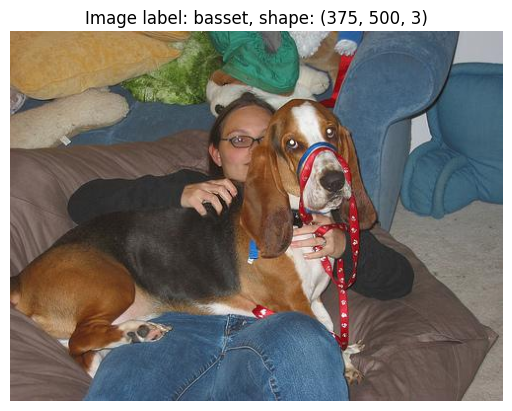

In [7]:
random_image_path = random.choice(list(images_path.glob("*/*/*.jpg")))
image_label = random_image_path.parent.stem

image = Image.open(random_image_path)
image_np = np.array(image)

plt.imshow(image_np)
plt.title(f"Image label: {image_label}, shape: {image_np.shape}")
plt.axis("off")

In [8]:
weights_effnetb0 = models.EfficientNet_B0_Weights.DEFAULT
transforms_effnetb0 = weights_effnetb0.transforms()
transforms_effnetb0

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_labels = load_data(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            transforms=transforms_effnetb0,
                                                            batch_size=BATCH_SIZE,
                                                            num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, class_labels

(<torch.utils.data.dataloader.DataLoader at 0x1cb5c2bcd10>,
 ['Afghan_hound',
  'African_hunting_dog',
  'Airedale',
  'American_Staffordshire_terrier',
  'Appenzeller',
  'Australian_terrier',
  'affenpinscher',
  'basenji',
  'basset',
  'beagle'])

In [10]:
effnetb0 = models.efficientnet_b0(weights=weights_effnetb0)

In [11]:
torchinfo.summary(model=effnetb0,
                 input_size=(32, 3, 224, 224),
                 col_names = ["input_size", "output_size", "num_params", "trainable"],
                 col_width=20,
                 row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [12]:
for param in effnetb0.features.parameters():
    param.requires_grad = False

In [13]:
output_shape = len(class_labels)

effnetb0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, 
                     inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True))

In [14]:
torchinfo.summary(model=effnetb0,
                  input_size=(32, 3, 224, 224),
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [15]:
loss_fn_effnetb0 = nn.CrossEntropyLoss()
optimizer_effnetb0 = torch.optim.Adam(effnetb0.parameters(),
                                      lr=0.001)

In [16]:
torch.manual_seed(42)

start = time.time()

results_effnetb0 = train(model=effnetb0,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn_effnetb0,
                         optimizer=optimizer_effnetb0,
                         epochs=10)

end = time.time()

train_time_effnet_b0 = end - start

print(f"Training time of model_1: {train_time_effnet_b0:.4f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.4353, Train acc: 68.19 % | Test loss: 0.7614, Train acc: 68.19 % 
Epoch: 2 | Train loss: 0.6534, Train acc: 88.60 % | Test loss: 0.4738, Train acc: 88.60 % 
Epoch: 3 | Train loss: 0.4564, Train acc: 91.53 % | Test loss: 0.3640, Train acc: 91.53 % 
Epoch: 4 | Train loss: 0.3786, Train acc: 92.19 % | Test loss: 0.3358, Train acc: 92.19 % 
Epoch: 5 | Train loss: 0.3108, Train acc: 93.88 % | Test loss: 0.2832, Train acc: 93.88 % 
Epoch: 6 | Train loss: 0.2951, Train acc: 92.94 % | Test loss: 0.2672, Train acc: 92.94 % 
Epoch: 7 | Train loss: 0.2636, Train acc: 94.75 % | Test loss: 0.2599, Train acc: 94.75 % 
Epoch: 8 | Train loss: 0.2395, Train acc: 95.15 % | Test loss: 0.2347, Train acc: 95.15 % 
Epoch: 9 | Train loss: 0.1992, Train acc: 95.94 % | Test loss: 0.2547, Train acc: 95.94 % 
Epoch: 10 | Train loss: 0.2013, Train acc: 95.68 % | Test loss: 0.2460, Train acc: 95.68 % 
Training time of model_1: 980.0078 seconds.


In [17]:
effnetb0_params_number = sum(p.numel() for p in effnetb0.parameters())
effnetb0_params_number

4020358

In [20]:
effnetb0_stats = {"train_loss": round(results_effnetb0["train_loss"][-1], 4),
                  "test_loss": round(results_effnetb0["test_loss"][-1], 4),
                  "train_acc": round(results_effnetb0["train_acc"][-1], 4),
                  "test_acc": round(results_effnetb0["test_acc"][-1], 4),
                  "training_time": round(train_time_effnet_b0, 4),
                  "params_number": effnetb0_params_number}

effnetb0_stats

{'train_loss': 0.2013,
 'test_loss': 0.246,
 'train_acc': 95.6782,
 'test_acc': 93.0804,
 'training_time': 980.0078,
 'params_number': 4020358}

In [21]:
weights_vgg16 = models.VGG16_Weights.DEFAULT
transforms_vgg16 = weights_vgg16.transforms()
transforms_vgg16

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
train_dataloader, test_dataloader, class_labels = load_data(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            transforms=transforms_vgg16,
                                                            batch_size=BATCH_SIZE,
                                                            num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, class_labels

(<torch.utils.data.dataloader.DataLoader at 0x1cb0053f9d0>,
 ['Afghan_hound',
  'African_hunting_dog',
  'Airedale',
  'American_Staffordshire_terrier',
  'Appenzeller',
  'Australian_terrier',
  'affenpinscher',
  'basenji',
  'basset',
  'beagle'])

In [23]:
vgg16 = models.vgg16(weights=weights_vgg16)

In [24]:
torchinfo.summary(model=vgg16,
                  input_size=(32, 3, 224, 224),
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"] )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [25]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [26]:
vgg16.classifier = nn.Sequential(
     nn.Linear(in_features=25088,
               out_features=4096,
               bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=4096,
              out_features=4096,
              bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=4096,
              out_features=output_shape,
              bias=True))

In [27]:
torchinfo.summary(model=vgg16,
                  input_size=(32, 3, 224, 224),
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"] )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [28]:
loss_fn_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = torch.optim.Adam(vgg16.parameters(), 
                                   lr=0.001)

In [29]:
torch.manual_seed(42)

start=time.time()

results_vgg16 = train(model=vgg16,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer_vgg16,
                      loss_fn=loss_fn_vgg16,
                      epochs=10)

end=time.time()

train_time_vgg16 = end - start

print(f"Training time of model_2: {train_time_vgg16:.4f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 2.9726, Train acc: 71.95 % | Test loss: 0.2164, Train acc: 71.95 % 
Epoch: 2 | Train loss: 0.1371, Train acc: 96.08 % | Test loss: 0.3710, Train acc: 96.08 % 
Epoch: 3 | Train loss: 0.0781, Train acc: 97.94 % | Test loss: 0.4155, Train acc: 97.94 % 
Epoch: 4 | Train loss: 0.0959, Train acc: 97.38 % | Test loss: 0.7621, Train acc: 97.38 % 
Epoch: 5 | Train loss: 0.2618, Train acc: 96.88 % | Test loss: 1.4741, Train acc: 96.88 % 
Epoch: 6 | Train loss: 0.2810, Train acc: 96.68 % | Test loss: 1.5086, Train acc: 96.68 % 
Epoch: 7 | Train loss: 0.2705, Train acc: 96.81 % | Test loss: 2.1337, Train acc: 96.81 % 
Epoch: 8 | Train loss: 0.5392, Train acc: 96.21 % | Test loss: 1.6486, Train acc: 96.21 % 
Epoch: 9 | Train loss: 0.2429, Train acc: 97.94 % | Test loss: 1.6734, Train acc: 97.94 % 
Epoch: 10 | Train loss: 0.2305, Train acc: 98.94 % | Test loss: 2.0549, Train acc: 98.94 % 
Training time of model_2: 2233.3846 seconds.


In [30]:
vgg16_params_number = sum(p.numel() for p in vgg16.parameters())
vgg16_params_number

134301514

In [31]:
vgg16_stats = {"train_loss": round(results_vgg16["train_loss"][-1], 4),
                "test_loss": round(results_vgg16["test_loss"][-1], 4),
                "train_acc": round(results_vgg16["train_acc"][-1], 4),
                "test_acc": round(results_vgg16["test_acc"][-1], 4),
                "training_time": round(train_time_vgg16, 4),
                "params_number": vgg16_params_number}

vgg16_stats

{'train_loss': 0.2305,
 'test_loss': 2.0549,
 'train_acc': 98.9362,
 'test_acc': 91.9147,
 'training_time': 2233.3846,
 'params_number': 134301514}

In [32]:
weights_resnet34 = models.ResNet34_Weights.DEFAULT 
transforms_resnet34 = weights_resnet34.transforms()
transforms_resnet34

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [33]:
train_dataloader, test_dataloader, class_labels = load_data(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            transforms=transforms_resnet34,
                                                            batch_size=BATCH_SIZE,
                                                            num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, class_labels

(<torch.utils.data.dataloader.DataLoader at 0x1cb00615b50>,
 ['Afghan_hound',
  'African_hunting_dog',
  'Airedale',
  'American_Staffordshire_terrier',
  'Appenzeller',
  'Australian_terrier',
  'affenpinscher',
  'basenji',
  'basset',
  'beagle'])

In [34]:
resnet34 = models.resnet34(weights=weights_resnet34)

In [35]:
torchinfo.summary(model=resnet34,
                  input_size=(32, 3, 224, 224),
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"] )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [36]:
for param in resnet34.conv1.parameters():
    param.requires_grad = False
for param in resnet34.bn1.parameters():
    param.requires_grad = False
for param in resnet34.layer1.parameters():
    param.requires_grad = False
for param in resnet34.layer2.parameters():
    param.requires_grad = False
for param in resnet34.layer3.parameters():
    param.requires_grad = False
for param in resnet34.layer4.parameters():
    param.requires_grad = False

In [37]:
resnet34.fc = nn.Linear(in_features=512,
                        out_features=output_shape,
                        bias=True)    

In [38]:
torchinfo.summary(model=resnet34,
                  input_size=(32, 3, 384, 384),
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"] )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 384, 384]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 384, 384]    [32, 64, 192, 192]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 192, 192]   [32, 64, 192, 192]   (128)                False
├─ReLU (relu)                            [32, 64, 192, 192]   [32, 64, 192, 192]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 192, 192]   [32, 64, 96, 96]     --                   --
├─Sequential (layer1)                    [32, 64, 96, 96]     [32, 64, 96, 96]     --                   False
│    └─BasicBlock (0)                    [32, 64, 96, 96]     [32, 64, 96, 96]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 96, 96]     [32, 64, 96, 96]     (36,864)             False
│    │    

In [39]:
loss_fn_resnet34 = nn.CrossEntropyLoss()
optimizer_resnet34 = torch.optim.Adam(resnet34.parameters(), 
                                      lr=0.001)

In [40]:
torch.manual_seed(42)

start = time.time()

results_resnet34 = train(model=resnet34,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer_resnet34,
                         loss_fn=loss_fn_resnet34,
                         epochs=10)

end = time.time()

train_time_resnet34 = end - start

print(f"Training time of model_2: {train_time_resnet34:.4f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.2182, Train acc: 70.12 % | Test loss: 0.4821, Train acc: 70.12 % 
Epoch: 2 | Train loss: 0.3632, Train acc: 93.95 % | Test loss: 0.2633, Train acc: 93.95 % 
Epoch: 3 | Train loss: 0.2320, Train acc: 96.61 % | Test loss: 0.1918, Train acc: 96.61 % 
Epoch: 4 | Train loss: 0.1694, Train acc: 96.88 % | Test loss: 0.1705, Train acc: 96.88 % 
Epoch: 5 | Train loss: 0.1389, Train acc: 97.54 % | Test loss: 0.1484, Train acc: 97.54 % 
Epoch: 6 | Train loss: 0.1196, Train acc: 97.61 % | Test loss: 0.1311, Train acc: 97.61 % 
Epoch: 7 | Train loss: 0.1141, Train acc: 97.45 % | Test loss: 0.1191, Train acc: 97.45 % 
Epoch: 8 | Train loss: 0.1073, Train acc: 97.98 % | Test loss: 0.1119, Train acc: 97.98 % 
Epoch: 9 | Train loss: 0.0798, Train acc: 98.87 % | Test loss: 0.1136, Train acc: 98.87 % 
Epoch: 10 | Train loss: 0.0766, Train acc: 98.80 % | Test loss: 0.1074, Train acc: 98.80 % 
Training time of model_2: 926.3721 seconds.


In [41]:
resnet34_params_number = sum(p.numel() for p in resnet34.parameters())
resnet34_params_number

21289802

In [42]:
resnet34_stats = {"train_loss": round(results_resnet34["train_loss"][-1], 4),
                  "test_loss": round(results_resnet34["test_loss"][-1], 4),
                  "train_acc": round(results_resnet34["train_acc"][-1], 4),
                  "test_acc": round(results_resnet34["test_acc"][-1], 4),
                  "training_time": round(train_time_resnet34, 4),
                  "params_number": resnet34_params_number}

resnet34_stats

{'train_loss': 0.0766,
 'test_loss': 0.1074,
 'train_acc': 98.8032,
 'test_acc': 96.5898,
 'training_time': 926.3721,
 'params_number': 21289802}

In [43]:
df = pd.DataFrame([effnetb0_stats, vgg16_stats, resnet34_stats], index = ["EfficientNet_B0","VGG16","ResNet34"])
df

,train_loss,test_loss,train_acc,test_acc,training_time,params_number
EfficientNet_B0,0.2013,0.2460,95.6782,93.0804,980.0078,4020358
VGG16,0.2305,2.0549,98.9362,91.9147,2233.3846,134301514
ResNet34,0.0766,0.1074,98.8032,96.5898,926.3721,21289802


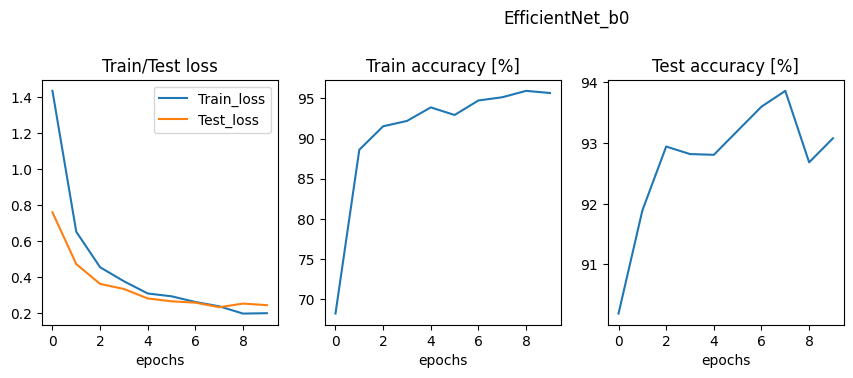

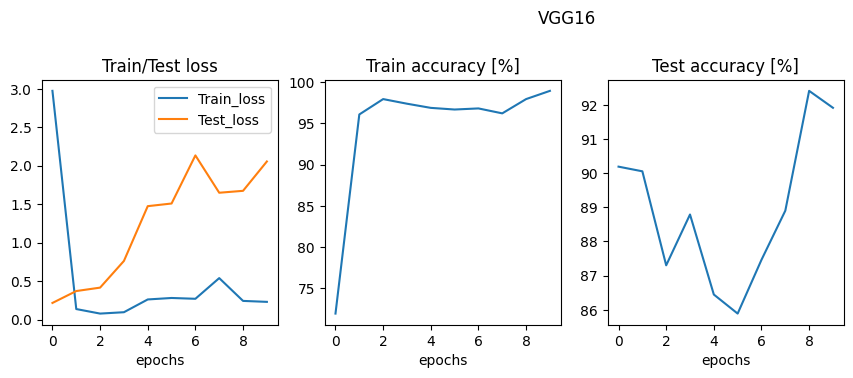

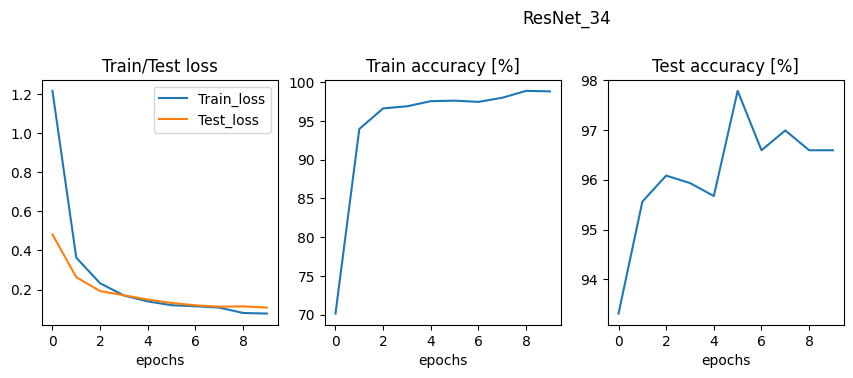

In [45]:
plot_curves(results_effnetb0, "EfficientNet_b0")
plot_curves(results_vgg16, "VGG16")
plot_curves(results_resnet34, "ResNet_34")

In [46]:
images_path = Path("data")

train_dir = images_path / "train"
test_dir = images_path / "test"
train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

In [47]:
weights_final_model = models.ResNet34_Weights.DEFAULT 
transforms_final_model = weights_final_model.transforms()

In [50]:
train_dataloader, test_dataloader, class_labels = load_data(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            transforms=transforms_final_model,
                                                            batch_size=BATCH_SIZE,
                                                            num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, len(class_labels)

(<torch.utils.data.dataloader.DataLoader at 0x1cbd77b4e10>,
 120)

In [51]:
output_shape = len(class_labels)

output_shape

120

In [52]:
final_model = models.resnet34(weights=weights_final_model)

In [53]:
for param in final_model.conv1.parameters():
    param.requires_grad = False
for param in final_model.bn1.parameters():
    param.requires_grad = False
for param in final_model.layer1.parameters():
    param.requires_grad = False
for param in final_model.layer2.parameters():
    param.requires_grad = False
for param in final_model.layer3.parameters():
    param.requires_grad = False
for param in final_model.layer4.parameters():
    param.requires_grad = False

final_model.fc = nn.Linear(in_features=512,
                           out_features=output_shape,
                           bias=True)    

In [54]:
torchinfo.summary(model=final_model,
                  input_size=(32, 3, 224, 224),
                  col_names = ["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 120]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [55]:
loss_fn_final_model = nn.CrossEntropyLoss()

optimizer_final_model = torch.optim.Adam(final_model.parameters(), 
                                         lr=0.001)

In [56]:
torch.manual_seed(42)

start = time.time()

results_final_model= train(model=final_model,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           optimizer=optimizer_final_model,
                           loss_fn=loss_fn_final_model,
                           epochs=20)

end = time.time()

train_time_final_model = end - start

print(f"Training time of final model: {train_time_final_model:.4f} seconds.")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.6488, Train acc: 63.34 % | Test loss: 0.7153, Train acc: 63.34 % 
Epoch: 2 | Train loss: 0.6695, Train acc: 81.36 % | Test loss: 0.5971, Train acc: 81.36 % 
Epoch: 3 | Train loss: 0.5333, Train acc: 84.37 % | Test loss: 0.5968, Train acc: 84.37 % 
Epoch: 4 | Train loss: 0.4668, Train acc: 85.65 % | Test loss: 0.5751, Train acc: 85.65 % 
Epoch: 5 | Train loss: 0.4107, Train acc: 87.47 % | Test loss: 0.5590, Train acc: 87.47 % 
Epoch: 6 | Train loss: 0.3786, Train acc: 88.16 % | Test loss: 0.5697, Train acc: 88.16 % 
Epoch: 7 | Train loss: 0.3415, Train acc: 89.34 % | Test loss: 0.5841, Train acc: 89.34 % 
Epoch: 8 | Train loss: 0.3215, Train acc: 89.77 % | Test loss: 0.5930, Train acc: 89.77 % 
Epoch: 9 | Train loss: 0.3044, Train acc: 90.30 % | Test loss: 0.5977, Train acc: 90.30 % 
Epoch: 10 | Train loss: 0.2874, Train acc: 90.64 % | Test loss: 0.6259, Train acc: 90.64 % 
Epoch: 11 | Train loss: 0.2674, Train acc: 91.20 % | Test loss: 0.6250, Train acc: 91.20 

In [57]:
MODEL_SAVE_PATH = "saved_model/final_model"

torch.save(obj=final_model.state_dict(),
           f = MODEL_SAVE_PATH)